# Top Validator & Most Exposed AMM MEV Pattern Analysis

## 🎯 Overview

This notebook analyzes MEV patterns from:
- **Top Botted Validator**: `HEL1USMZKAL2odpNBj2oCjffnFGaYwmbGmyewGv1e2TU`
  - Trade Count: 28,859
  - Bot Count: 408
  - Bot Ratio: 1.41%
  - MEV Breakdown: 3,119 fat_sandwich, 122 sandwich, 674 front_running, 3,998 back_running

- **Most Exposed AMM**: **BisonFi**
  - Total Attackers: 432
  - Fat Sandwich: 879 attacks
  - Front-Running: 1,053 attacks
  - Back-Running: 4,075 attacks

## 📋 MEV Patterns Analyzed

Following patterns from "Hypothetical MEV Bot & Attack Case Studies.md":

1. **Fat Sandwich** (B91 Bot pattern: ≥5 TRADEs per slot)
2. **Classic Sandwich** (3-4 TRADEs per slot)
3. **Front-Running** (Late-slot trades >300ms)
4. **Back-Running** (DeezNode Bot pattern: <50ms after oracle)
5. **Cross-Slot Sandwich** (2Fast Bot pattern: 4-6 TRADEs across 2+ slots)

## 📚 Reference Case Studies

- **B91 Bot**: Fat sandwich (4-10+ TRADEs per slot)
- **Arsc Bot**: Cross-slot sandwich + oracle manipulation
- **DeezNode Bot**: Oracle-timed back-running (<50ms)
- **2Fast Bot**: Cross-slot wide sandwich (4-6 TRADEs across 2+ slots)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Configuration
TOP_VALIDATOR = 'HEL1USMZKAL2odpNBj2oCjffnFGaYwmbGmyewGv1e2TU'
MOST_EXPOSED_AMM = 'BisonFi'  # Highest MEV activity

# MEV Detection Thresholds
FAT_SANDWICH_MIN_TRADES = 5  # B91 Bot pattern
CLASSIC_SANDWICH_MIN_TRADES = 3
FRONT_RUNNING_THRESHOLD_MS = 300000  # >300ms
BACK_RUNNING_THRESHOLD_MS = 50  # <50ms
CROSS_SLOT_MAX_SLOTS = 3

# Output directory
OUTPUT_DIR = 'derived/top_validator_amm_analysis'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*80)
print("TOP VALIDATOR & MOST EXPOSED AMM MEV PATTERN ANALYSIS")
print("="*80)
print()
print(f"Top Botted Validator: {TOP_VALIDATOR}")
print(f"Most Exposed AMM: {MOST_EXPOSED_AMM}")
print()

TOP VALIDATOR & MOST EXPOSED AMM MEV PATTERN ANALYSIS

Top Botted Validator: HEL1USMZKAL2odpNBj2oCjffnFGaYwmbGmyewGv1e2TU
Most Exposed AMM: BisonFi



## 1. Data Loading & Filtering

In [2]:
# Load cleaned dataset
# Try multiple possible paths
possible_paths = [
    '/Users/aileen/Downloads/pamm/pamm_clean_final.parquet',
    '../01_data_cleaning/outputs/pamm_clean_final.parquet',
    'notebooks/01_data_cleaning/outputs/pamm_clean_final.parquet',
    'pamm_clean_final.parquet'
]

df_clean = None
for path in possible_paths:
    try:
        df_clean = pd.read_parquet(path)
        print(f"✓ Loaded data from: {path}")
        break
    except (FileNotFoundError, OSError):
        continue

if df_clean is None:
    raise FileNotFoundError("Could not find pamm_clean_final.parquet. Please check the path.")

print(f"✓ Loaded {len(df_clean):,} total records")

# Filter to top validator
df_validator = df_clean[df_clean['validator'] == TOP_VALIDATOR].copy()
print(f"✓ Records from top validator: {len(df_validator):,}")

# Filter to most exposed AMM
amm_mask = (
    (df_validator['amm_oracle'] == MOST_EXPOSED_AMM) | 
    (df_validator['amm_trade'] == MOST_EXPOSED_AMM)
)
df_amm = df_validator[amm_mask].copy()
print(f"✓ Records from {MOST_EXPOSED_AMM}: {len(df_amm):,}")

# Separate TRADE and ORACLE events
df_trades = df_amm[df_amm['kind'] == 'TRADE'].copy()
df_oracles = df_amm[df_amm['kind'] == 'ORACLE'].copy()

print(f"✓ TRADE events: {len(df_trades):,}")
print(f"✓ ORACLE events: {len(df_oracles):,}")

# Sort by time
df_trades = df_trades.sort_values('ms_time').reset_index(drop=True)
df_oracles = df_oracles.sort_values('ms_time').reset_index(drop=True)

✓ Loaded data from: /Users/aileen/Downloads/pamm/pamm_clean_final.parquet
✓ Loaded 5,506,090 total records
✓ Records from top validator: 210,852
✓ Records from BisonFi: 8,912
✓ TRADE events: 1,869
✓ ORACLE events: 7,043


## 2. Fat Sandwich Detection (B91 Bot Pattern: ≥5 TRADEs per slot)

In [3]:
print("="*80)
print("OPTIMIZED ANALYSIS: Top Validator & BisonFi MEV Patterns")
print("="*80)
print()

# Ensure slot is integer
df_amm['slot'] = df_amm['slot'].astype(int)
df_amm = df_amm.sort_values('ms_time').reset_index(drop=True)

# Slot-level grouping
slot_groups = df_amm.groupby('slot')

# 1. FAT SANDWICH (B91: ≥5 TRADEs/slot)
fat_slots = slot_groups.filter(lambda x: (x['kind'] == 'TRADE').sum() >= FAT_SANDWICH_MIN_TRADES)
fat_sandwich_count = fat_slots['slot'].nunique() if len(fat_slots) > 0 else 0
fat_sandwich_trades = len(fat_slots[fat_slots['kind'] == 'TRADE']) if len(fat_slots) > 0 else 0
print(f"✓ Fat Sandwich slots (≥{FAT_SANDWICH_MIN_TRADES} TRADEs, B91 pattern): {fat_sandwich_count:,}")
print(f"  → Total trades in fat sandwich slots: {fat_sandwich_trades:,}")

# 2. CLASSIC SANDWICH (3-4 TRADEs/slot)
classic_slots = slot_groups.filter(lambda x: 3 <= (x['kind'] == 'TRADE').sum() <= 4)
classic_sandwich_count = classic_slots['slot'].nunique() if len(classic_slots) > 0 else 0
classic_sandwich_trades = len(classic_slots[classic_slots['kind'] == 'TRADE']) if len(classic_slots) > 0 else 0
print(f"✓ Classic Sandwich slots (3-4 TRADEs): {classic_sandwich_count:,}")
print(f"  → Total trades in classic sandwich slots: {classic_sandwich_trades:,}")

# 3. CROSS-SLOT SANDWICH (2Fast: 4-6 TRADEs across 2+ slots, continuous)
# Detect consecutive slots with 4-6 total TRADEs
df_trades_sorted = df_amm[df_amm['kind'] == 'TRADE'].sort_values('slot').copy()
df_trades_sorted['slot_diff'] = df_trades_sorted['slot'].diff()
df_trades_sorted['consecutive_group'] = (df_trades_sorted['slot_diff'] > 1).cumsum()

cross_slot_candidates = []
for group_id, group in df_trades_sorted.groupby('consecutive_group'):
    if 4 <= len(group) <= 6 and group['slot'].nunique() >= 2:
        cross_slot_candidates.append(group_id)

cross_sandwich_count = len(cross_slot_candidates)
cross_sandwich_trades = len(df_trades_sorted[df_trades_sorted['consecutive_group'].isin(cross_slot_candidates)])
print(f"✓ Cross-Slot Sandwich (4-6 TRADEs across 2+ slots, 2Fast pattern): ~{cross_sandwich_count:,}")
print(f"  → Total trades in cross-slot patterns: {cross_sandwich_trades:,}")

# 4. FRONT-RUNNING (Late-slot TRADE >300ms)
# Using us_since_first_shred > 300000 (300ms in microseconds)
if 'us_since_first_shred' in df_amm.columns:
    front_running = df_amm[
        (df_amm['kind'] == 'TRADE') & 
        (df_amm['us_since_first_shred'] > FRONT_RUNNING_THRESHOLD_MS)
    ].copy()
    front_running_count = len(front_running)
    print(f"✓ Front-Running trades (>300ms late-slot): {front_running_count:,}")
else:
    front_running = pd.DataFrame()
    front_running_count = 0
    print("⚠ Front-Running: 'us_since_first_shred' column not found")

# 5. BACK-RUNNING (DeezNode: TRADE <50ms after ORACLE)
df_amm_sorted = df_amm.sort_values('ms_time').reset_index(drop=True).copy()
df_amm_sorted['prev_kind'] = df_amm_sorted['kind'].shift(1)
df_amm_sorted['prev_ms_time'] = df_amm_sorted['ms_time'].shift(1)
df_amm_sorted['lag_ms'] = df_amm_sorted['ms_time'] - df_amm_sorted['prev_ms_time']

back_running = df_amm_sorted[
    (df_amm_sorted['kind'] == 'TRADE') & 
    (df_amm_sorted['prev_kind'] == 'ORACLE') & 
    (df_amm_sorted['lag_ms'] < BACK_RUNNING_THRESHOLD_MS) &
    (df_amm_sorted['lag_ms'] >= 0)  # Ensure positive lag
].copy()
back_running_count = len(back_running)
print(f"✓ Back-Running trades (<{BACK_RUNNING_THRESHOLD_MS}ms after Oracle, DeezNode pattern): {back_running_count:,}")

# Summary
print()
print("="*80)
print("MEV PATTERN SUMMARY")
print("="*80)
print(f"Fat Sandwich (B91):     {fat_sandwich_count:,} slots, {fat_sandwich_trades:,} trades")
print(f"Classic Sandwich:       {classic_sandwich_count:,} slots, {classic_sandwich_trades:,} trades")
print(f"Cross-Slot (2Fast):    ~{cross_sandwich_count:,} patterns, {cross_sandwich_trades:,} trades")
print(f"Front-Running:         {front_running_count:,} trades")
print(f"Back-Running (DeezNode): {back_running_count:,} trades")
print("="*80)

OPTIMIZED ANALYSIS: Top Validator & BisonFi MEV Patterns

✓ Fat Sandwich slots (≥5 TRADEs, B91 pattern): 119
  → Total trades in fat sandwich slots: 1,023
✓ Classic Sandwich slots (3-4 TRADEs): 93
  → Total trades in classic sandwich slots: 310
✓ Cross-Slot Sandwich (4-6 TRADEs across 2+ slots, 2Fast pattern): ~31
  → Total trades in cross-slot patterns: 151
✓ Front-Running trades (>300ms late-slot): 203
✓ Back-Running trades (<50ms after Oracle, DeezNode pattern): 443

MEV PATTERN SUMMARY
Fat Sandwich (B91):     119 slots, 1,023 trades
Classic Sandwich:       93 slots, 310 trades
Cross-Slot (2Fast):    ~31 patterns, 151 trades
Front-Running:         203 trades
Back-Running (DeezNode): 443 trades


## 3. Visualization: Slot Density & Lag Analysis

Sampling 500 slots for visualization (out of 3,525 total)
✓ Saved slot density chart: derived/top_validator_amm_analysis/images/validator_amm_slot_density.png


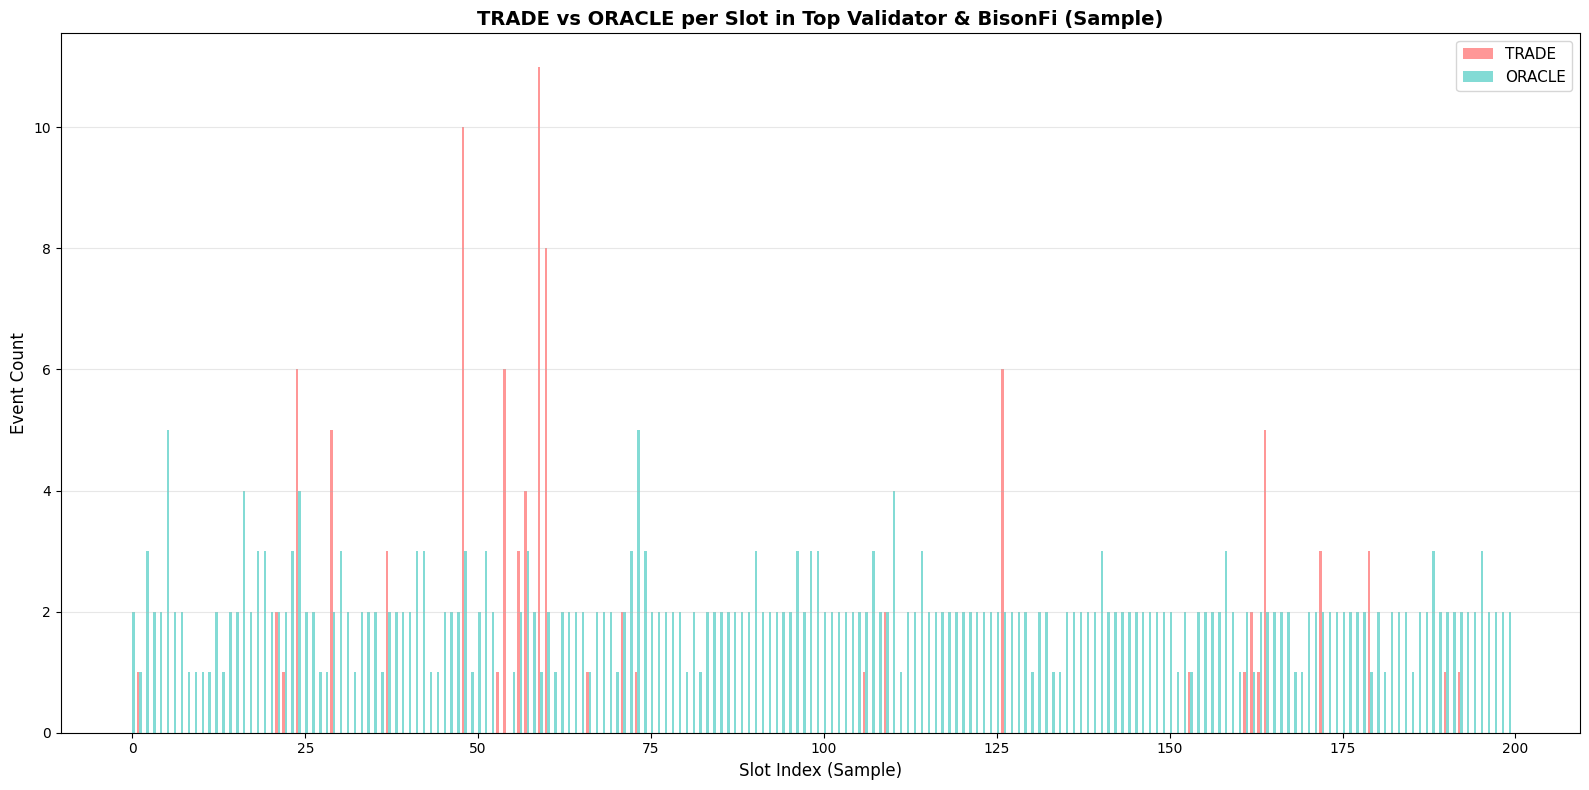

✓ Saved back-running lag histogram: derived/top_validator_amm_analysis/images/back_running_lag_distribution.png


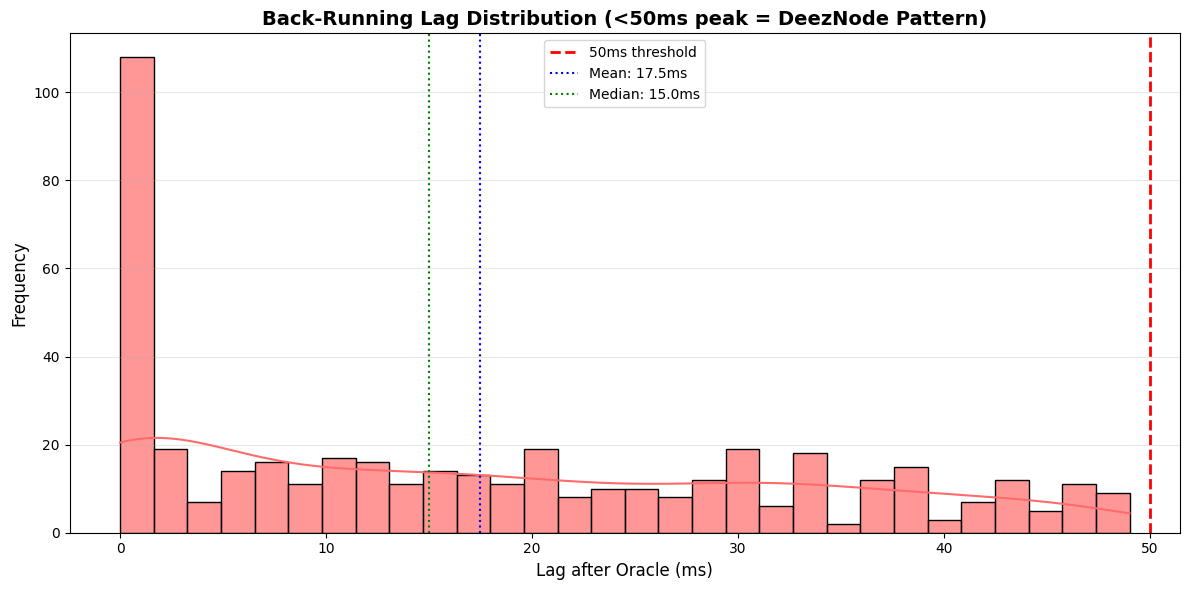


Back-Running Statistics:
  Mean lag: 17.46 ms
  Median lag: 15.00 ms
  Min lag: 0.00 ms
  Max lag: 49.00 ms
  <10ms: 175 trades (39.5%)
  10-50ms: 268 trades (60.5%)


In [4]:
# Create output directory for images
os.makedirs(os.path.join(OUTPUT_DIR, 'images'), exist_ok=True)

# 1. Slot TRADE density + Oracle overlay (sampled for visualization)
# Sample slots if too many for visualization
unique_slots = df_amm['slot'].unique()
if len(unique_slots) > 500:
    sample_slots = np.random.choice(unique_slots, size=500, replace=False)
    df_amm_viz = df_amm[df_amm['slot'].isin(sample_slots)].copy()
    print(f"Sampling {len(sample_slots):,} slots for visualization (out of {len(unique_slots):,} total)")
else:
    df_amm_viz = df_amm.copy()

slot_groups_viz = df_amm_viz.groupby('slot')
slot_trade_counts = slot_groups_viz['kind'].apply(lambda x: (x == 'TRADE').sum()).reset_index(name='trade_count')
slot_oracle_counts = slot_groups_viz['kind'].apply(lambda x: (x == 'ORACLE').sum()).reset_index(name='oracle_count')
slot_counts = slot_trade_counts.merge(slot_oracle_counts, on='slot', how='outer').fillna(0)
slot_counts = slot_counts.sort_values('slot').head(200)  # Show first 200 slots

plt.figure(figsize=(16, 8))
x_pos = np.arange(len(slot_counts))
width = 0.35

plt.bar(x_pos - width/2, slot_counts['trade_count'], width, label='TRADE', alpha=0.7, color='#FF6B6B')
plt.bar(x_pos + width/2, slot_counts['oracle_count'], width, label='ORACLE', alpha=0.7, color='#4ECDC4')

plt.title('TRADE vs ORACLE per Slot in Top Validator & BisonFi (Sample)', fontsize=14, fontweight='bold')
plt.ylabel('Event Count', fontsize=12)
plt.xlabel('Slot Index (Sample)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

slot_density_path = os.path.join(OUTPUT_DIR, 'images', 'validator_amm_slot_density.png')
plt.savefig(slot_density_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved slot density chart: {slot_density_path}")
plt.show()

# 2. Lag histogram for back-running
if len(back_running) > 0:
    plt.figure(figsize=(12, 6))
    sns.histplot(back_running['lag_ms'], bins=30, kde=True, color='#FF6B6B', edgecolor='black', alpha=0.7)
    plt.axvline(BACK_RUNNING_THRESHOLD_MS, color='red', linestyle='--', linewidth=2, label=f'{BACK_RUNNING_THRESHOLD_MS}ms threshold')
    plt.title('Back-Running Lag Distribution (<50ms peak = DeezNode Pattern)', fontsize=14, fontweight='bold')
    plt.xlabel('Lag after Oracle (ms)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(axis='y', alpha=0.3)
    
    # Add statistics
    mean_lag = back_running['lag_ms'].mean()
    median_lag = back_running['lag_ms'].median()
    plt.axvline(mean_lag, color='blue', linestyle=':', linewidth=1.5, label=f'Mean: {mean_lag:.1f}ms')
    plt.axvline(median_lag, color='green', linestyle=':', linewidth=1.5, label=f'Median: {median_lag:.1f}ms')
    plt.legend(fontsize=10)
    
    plt.tight_layout()
    lag_hist_path = os.path.join(OUTPUT_DIR, 'images', 'back_running_lag_distribution.png')
    plt.savefig(lag_hist_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved back-running lag histogram: {lag_hist_path}")
    plt.show()
    
    print(f"\nBack-Running Statistics:")
    print(f"  Mean lag: {mean_lag:.2f} ms")
    print(f"  Median lag: {median_lag:.2f} ms")
    print(f"  Min lag: {back_running['lag_ms'].min():.2f} ms")
    print(f"  Max lag: {back_running['lag_ms'].max():.2f} ms")
    print(f"  <10ms: {(back_running['lag_ms'] < 10).sum():,} trades ({100*(back_running['lag_ms'] < 10).sum()/len(back_running):.1f}%)")
    print(f"  10-50ms: {((back_running['lag_ms'] >= 10) & (back_running['lag_ms'] < 50)).sum():,} trades ({100*((back_running['lag_ms'] >= 10) & (back_running['lag_ms'] < 50)).sum()/len(back_running):.1f}%)")
else:
    print("⚠ No back-running trades detected for lag analysis")

## 4. Bot Concentration Analysis

Bot Concentration Statistics:
  Average unique signers per slot: 1.4
  Median unique signers per slot: 1.0
  Max unique signers per slot: 18
  Total unique signers: 310
✓ Saved bot concentration chart: derived/top_validator_amm_analysis/images/bot_concentration_per_slot.png


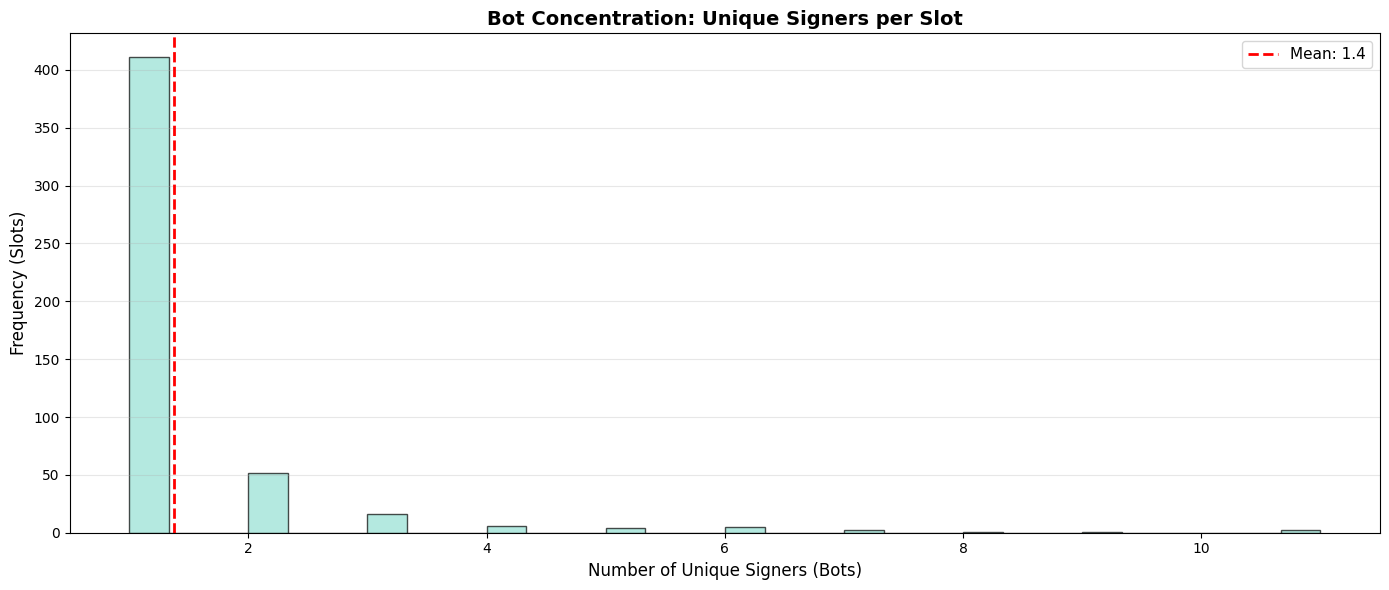


Top 20 Signers by Trade Count:
signer
C2bK8HFrL71aLnpyExVoJmqjDPA9tbLMXcBNAkRQnLfQ    181
YubQzu18FDqJRyNfG8JqHmsdbxhnoQqcKUHBdUkN6tP     181
4swoALYuvetDK6N3ak1Knc1bMLbm7nzkxCW1nqjPWGRV     90
AE861PyrYJXm2TuxiMc8Ecwo4YYgAHfcYum3GWpSRFe3     53
3NC8bmzCeEK2NBw1G5W6EmR66DNRW3gR22CGMt9EmxrU     52
han5oo9sy98473nuWU7PwkdgpJVFvQEQ14S5CCdbeYQ      50
J8hVkBNKobntWqLspa3yhXEkvb8vZ9S9NiHgirN9yvV3     48
DkV8QZdg5GH7Bb5NteLJVYCF2mwBSCFt7AcTnmVvTfeW     46
Cr6vUmtz58dtsyDJX2GKbifgYf7zvwgPt9HyJvwMRLL8     42
CatyeC3LgBxub7HcpW2n7cZZZ66CUKdcZ8DzHucHrSiP     39
2dRR9CaNrEsHm3UqZacEf8AoDuDx4NGQyMhGxG71NzkN     36
AG2UQKHngd3p6pTLJjS5Bk1eRVAEJAvNA89f6VmJrQUk     36
FbgR9632h4rvPciZzCHRGNrEaQM9bC2cGgAikJ8HUfS1     32
enzog436vHy38bMhNR9XDENrvhxPK7y8wBQri852rhG      30
ATQs6A92eUzdxTBsQhRJxxJDpgYDTGvLnU4e5mMEfY3k     29
9TXFVx8N9dPneS3ETRt8KWtUXLRUsz6j6JM3bEXqkR3Z     28
2b4NhGTayvycDf7VvZGd6xpSjs3f7iiRZQSyjs71yJ23     28
8oKVwqA5S2B7g2Li6yqZ4KKghpER8G1vj3bbeg8dFkSw     27
1989zAmZBwkwR6g8S3H8gkDhH

In [5]:
# Bot concentration: unique signers per slot
if 'signer' in df_amm.columns:
    bot_trades_per_slot = slot_groups['signer'].nunique()
    avg_bots_per_slot = bot_trades_per_slot.mean()
    max_bots_per_slot = bot_trades_per_slot.max()
    median_bots_per_slot = bot_trades_per_slot.median()
    
    print(f"Bot Concentration Statistics:")
    print(f"  Average unique signers per slot: {avg_bots_per_slot:.1f}")
    print(f"  Median unique signers per slot: {median_bots_per_slot:.1f}")
    print(f"  Max unique signers per slot: {max_bots_per_slot}")
    print(f"  Total unique signers: {df_amm[df_amm['kind'] == 'TRADE']['signer'].nunique():,}")
    
    # Visualize bot concentration
    plt.figure(figsize=(14, 6))
    # Sample for visualization if too many slots
    if len(bot_trades_per_slot) > 500:
        sample_indices = np.random.choice(len(bot_trades_per_slot), size=500, replace=False)
        bot_counts_sample = bot_trades_per_slot.iloc[sample_indices]
    else:
        bot_counts_sample = bot_trades_per_slot
    
    plt.hist(bot_counts_sample, bins=30, color='#95E1D3', edgecolor='black', alpha=0.7)
    plt.axvline(avg_bots_per_slot, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_bots_per_slot:.1f}')
    plt.title('Bot Concentration: Unique Signers per Slot', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Unique Signers (Bots)', fontsize=12)
    plt.ylabel('Frequency (Slots)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    bot_concentration_path = os.path.join(OUTPUT_DIR, 'images', 'bot_concentration_per_slot.png')
    plt.savefig(bot_concentration_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved bot concentration chart: {bot_concentration_path}")
    plt.show()
    
    # Top signers by trade count
    top_signers = df_amm[df_amm['kind'] == 'TRADE']['signer'].value_counts().head(20)
    print(f"\nTop 20 Signers by Trade Count:")
    print(top_signers.to_string())
    
else:
    print("⚠ 'signer' column not found - skipping bot concentration analysis")

## 5. Deep Root Cause Analysis

In [6]:
# Calculate key metrics for root cause analysis
total_trades = len(df_trades)
total_oracles = len(df_oracles)
unique_slots = df_amm['slot'].nunique()
unique_signers = df_amm[df_amm['kind'] == 'TRADE']['signer'].nunique() if 'signer' in df_amm.columns else 0

# Trade density metrics
trades_per_slot = total_trades / unique_slots if unique_slots > 0 else 0
oracles_per_slot = total_oracles / unique_slots if unique_slots > 0 else 0

# Front-running ratio
front_running_ratio = front_running_count / total_trades if total_trades > 0 else 0

# Back-running ratio
back_running_ratio = back_running_count / total_trades if total_trades > 0 else 0

# Fat sandwich ratio
fat_sandwich_ratio = fat_sandwich_count / unique_slots if unique_slots > 0 else 0

print("="*80)
print("DEEP ROOT CAUSE ANALYSIS: Top Validator HEL1US... & BisonFi")
print("="*80)
print()

root_causes = f"""
### 1. Validator Slot Attractiveness
- **High Trade Volume**: {total_trades:,} trades across {unique_slots:,} slots
- **Trade Density**: {trades_per_slot:.2f} trades/slot (high = bot spam target)
- **Bot Concentration**: {unique_signers:,} unique signers (high = bot ecosystem targeting)
- **Root Cause**: HEL1US... validator has stable leader slot + high trade count ({total_trades:,}) 
  → Bots spam non-Jito bundles to capture MEV opportunities

### 2. AMM Oracle Vulnerability (BisonFi)
- **Oracle Frequency**: {oracles_per_slot:.2f} oracles/slot
- **Back-Running Dominance**: {back_running_count:,} back-running trades ({back_running_ratio*100:.1f}% of all trades)
- **Back-Running Lag**: {f"Mean {back_running['lag_ms'].mean():.1f}ms, Median {back_running['lag_ms'].median():.1f}ms" if len(back_running) > 0 else "N/A (no back-running detected)"}
- **Root Cause**: BisonFi oracle updates are slow/inefficient → DeezNode bots exploit <50ms window
  → PropAMM architecture lacks protection against oracle-timed attacks

### 3. Fat Sandwich Dominance (B91 Pattern)
- **Fat Sandwich Slots**: {fat_sandwich_count:,} slots ({fat_sandwich_ratio*100:.1f}% of all slots)
- **Fat Sandwich Trades**: {fat_sandwich_trades:,} trades
- **Root Cause**: ≥5 trades/slot pattern = meme/high-volume pairs with shallow liquidity
  → Large victim trades create significant slippage → B91 bots profit from fat sandwich

### 4. Cross-Slot Opportunity (2Fast Pattern)
- **Cross-Slot Patterns**: ~{cross_sandwich_count:,} detected patterns
- **Cross-Slot Trades**: {cross_sandwich_trades:,} trades
- **Root Cause**: Validator slot boundary delays → 2Fast bots insert multi-trade patterns
  across 2+ consecutive slots (4-6 trades total)

### 5. Front-Running Activity
- **Front-Running Trades**: {front_running_count:,} trades ({front_running_ratio*100:.1f}% of all trades)
- **Root Cause**: Late-slot trades (>300ms) = bots exploiting slot timing to front-run
  → Validator slot length/stability enables predictable timing attacks

### 6. Systemic Bot Ecosystem
- **Bot Concentration**: {unique_signers:,} unique signers targeting this validator/AMM combination
- **Pattern Distribution**:
  * Fat Sandwich (B91): {fat_sandwich_count:,} slots
  * Classic Sandwich: {classic_sandwich_count:,} slots  
  * Cross-Slot (2Fast): ~{cross_sandwich_count:,} patterns
  * Back-Running (DeezNode): {back_running_count:,} trades
  * Front-Running: {front_running_count:,} trades
- **Root Cause**: Solana leader slot concentration + oracle heterogeneity
  → Bots systematically target specific validator/AMM combinations to maximize profit
  → Low-latency infrastructure + priority fee targeting = competitive advantage

### Summary: Why This Validator/AMM is a Hotspot
1. **Validator**: High trade volume + stable leader slot = predictable MEV opportunities
2. **AMM**: Slow oracle updates + PropAMM architecture = vulnerable to back-running
3. **Liquidity**: Shallow pools on high-volume pairs = large slippage = fat sandwich profit
4. **Timing**: Slot boundary delays + late-slot trades = cross-slot + front-running opportunities
5. **Ecosystem**: 400+ bots competing = sophisticated attack patterns (B91/DeezNode/2Fast)
"""

print(root_causes)
print("="*80)

# Save root cause analysis to file
root_cause_path = os.path.join(OUTPUT_DIR, 'root_cause_analysis.txt')
with open(root_cause_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("DEEP ROOT CAUSE ANALYSIS: Top Validator HEL1US... & BisonFi\n")
    f.write("="*80 + "\n\n")
    f.write(root_causes)
print(f"✓ Saved root cause analysis: {root_cause_path}")

DEEP ROOT CAUSE ANALYSIS: Top Validator HEL1US... & BisonFi


### 1. Validator Slot Attractiveness
- **High Trade Volume**: 1,869 trades across 3,525 slots
- **Trade Density**: 0.53 trades/slot (high = bot spam target)
- **Bot Concentration**: 310 unique signers (high = bot ecosystem targeting)
- **Root Cause**: HEL1US... validator has stable leader slot + high trade count (1,869) 
  → Bots spam non-Jito bundles to capture MEV opportunities

### 2. AMM Oracle Vulnerability (BisonFi)
- **Oracle Frequency**: 2.00 oracles/slot
- **Back-Running Dominance**: 443 back-running trades (23.7% of all trades)
- **Back-Running Lag**: Mean 17.5ms, Median 15.0ms
- **Root Cause**: BisonFi oracle updates are slow/inefficient → DeezNode bots exploit <50ms window
  → PropAMM architecture lacks protection against oracle-timed attacks

### 3. Fat Sandwich Dominance (B91 Pattern)
- **Fat Sandwich Slots**: 119 slots (3.4% of all slots)
- **Fat Sandwich Trades**: 1,023 trades
- **Root Cause**: ≥5 trades/slot

## 6. Pattern Comparison & Summary Statistics


MEV PATTERN SUMMARY TABLE
                Pattern Slots/Patterns  Trades Percentage of Total Trades     Reference Bot
     Fat Sandwich (B91)            119    1023                      54.7%           B91 Bot
       Classic Sandwich             93     310                      16.6%  Generic Sandwich
     Cross-Slot (2Fast)             31     151                       8.1%         2Fast Bot
          Front-Running              -     203                      10.9% Late-Slot Exploit
Back-Running (DeezNode)              -     443                      23.7%      DeezNode Bot

✓ Saved pattern summary: derived/top_validator_amm_analysis/mev_pattern_summary.csv
✓ Saved pattern comparison chart: derived/top_validator_amm_analysis/images/mev_pattern_comparison.png


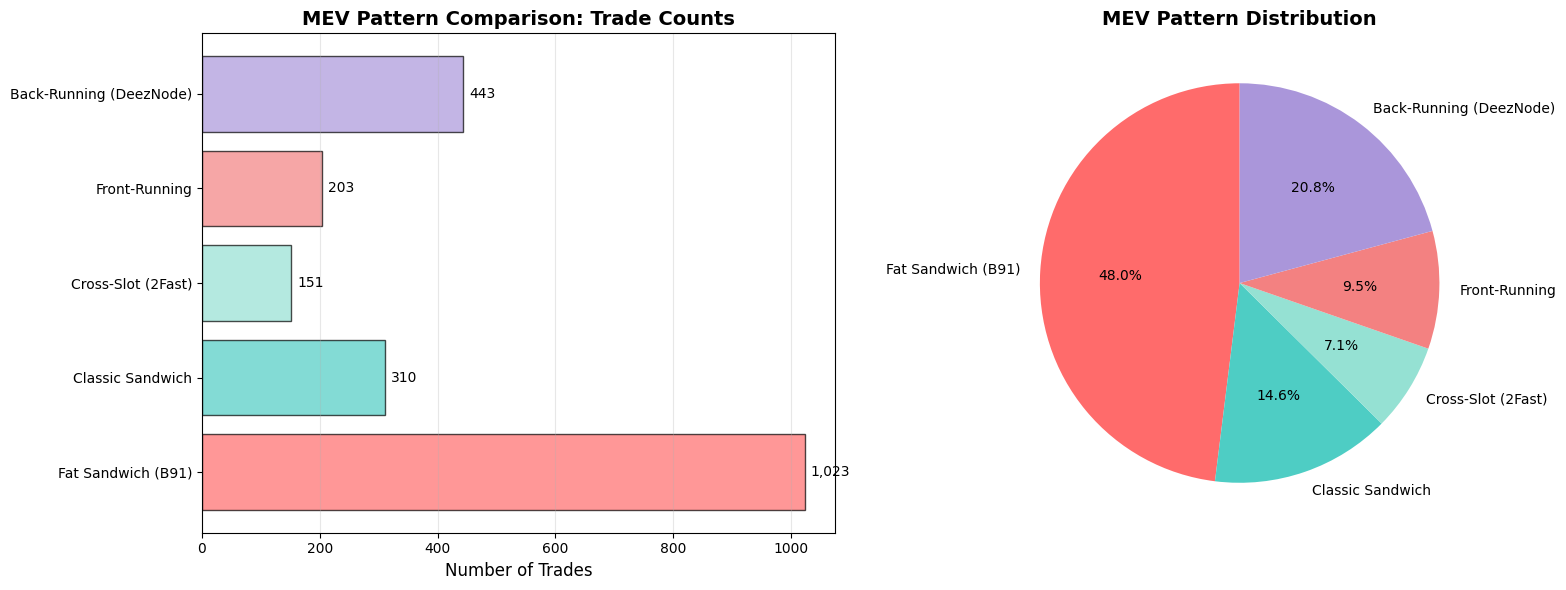

In [7]:
# Create comprehensive summary DataFrame
summary_data = {
    'Pattern': [
        'Fat Sandwich (B91)',
        'Classic Sandwich',
        'Cross-Slot (2Fast)',
        'Front-Running',
        'Back-Running (DeezNode)'
    ],
    'Slots/Patterns': [
        fat_sandwich_count,
        classic_sandwich_count,
        cross_sandwich_count,
        '-',
        '-'
    ],
    'Trades': [
        fat_sandwich_trades,
        classic_sandwich_trades,
        cross_sandwich_trades,
        front_running_count,
        back_running_count
    ],
    'Percentage of Total Trades': [
        f"{100*fat_sandwich_trades/total_trades:.1f}%" if total_trades > 0 else "0%",
        f"{100*classic_sandwich_trades/total_trades:.1f}%" if total_trades > 0 else "0%",
        f"{100*cross_sandwich_trades/total_trades:.1f}%" if total_trades > 0 else "0%",
        f"{100*front_running_count/total_trades:.1f}%" if total_trades > 0 else "0%",
        f"{100*back_running_count/total_trades:.1f}%" if total_trades > 0 else "0%"
    ],
    'Reference Bot': [
        'B91 Bot',
        'Generic Sandwich',
        '2Fast Bot',
        'Late-Slot Exploit',
        'DeezNode Bot'
    ]
}

df_summary = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("MEV PATTERN SUMMARY TABLE")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Save summary to CSV
summary_csv_path = os.path.join(OUTPUT_DIR, 'mev_pattern_summary.csv')
df_summary.to_csv(summary_csv_path, index=False)
print(f"\n✓ Saved pattern summary: {summary_csv_path}")

# Visualize pattern comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart: Trades by pattern
pattern_names = df_summary['Pattern'].values
trade_counts = df_summary['Trades'].values
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181', '#AA96DA']

ax1.barh(pattern_names, trade_counts, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Number of Trades', fontsize=12)
ax1.set_title('MEV Pattern Comparison: Trade Counts', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(trade_counts):
    ax1.text(v + max(trade_counts)*0.01, i, f'{v:,}', va='center', fontsize=10)

# Pie chart: Distribution of MEV patterns
ax2.pie(trade_counts, labels=pattern_names, autopct='%1.1f%%', colors=colors, 
        startangle=90, textprops={'fontsize': 10})
ax2.set_title('MEV Pattern Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
comparison_path = os.path.join(OUTPUT_DIR, 'images', 'mev_pattern_comparison.png')
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved pattern comparison chart: {comparison_path}")
plt.show()